In [113]:
import numba.cuda as cuda
import numba as nb
import numpy as np
import math
from math import asinh, sqrt, atan
from time import time
from math import pi
import os

eps=1e-18
PI = pi

_file = open("cuda_out.txt", "w")

@cuda.jit
def f_cuda(p0, p1, p2):
  #print(type(p))
  x, y, z = abs(p0), abs(p1), abs(p2)
  return + y / 2.0 * (z**2 - x**2) * asinh(y / (sqrt(x**2 + z**2) + eps)) \
         + z / 2.0 * (y**2 - x**2) * asinh(z / (sqrt(x**2 + y**2) + eps)) \
         - x*y*z * atan(y*z / (x * sqrt(x**2 + y**2 + z**2) + eps))       \
         + 1.0 / 6.0 * (2*x**2 - y**2 - z**2) * sqrt(x**2 + y**2 + z**2)

# newell g
@cuda.jit
def g_cuda(p0, p1, p2):
  x, y, z = p0, p1, abs(p2)
  return + x*y*z * asinh(z / (sqrt(x**2 + y**2) + eps))                         \
         + y / 6.0 * (3.0 * z**2 - y**2) * asinh(x / (sqrt(y**2 + z**2) + eps)) \
         + x / 6.0 * (3.0 * z**2 - x**2) * asinh(y / (sqrt(x**2 + z**2) + eps)) \
         - z**3 / 6.0 * atan(x*y / (z * sqrt(x**2 + y**2 + z**2) + eps))        \
         - z * y**2 / 2.0 * atan(x*z / (y * sqrt(x**2 + y**2 + z**2) + eps))    \
         - z * x**2 / 2.0 * atan(y*z / (x * sqrt(x**2 + y**2 + z**2) + eps))    \
         - x*y * sqrt(x**2 + y**2 + z**2) / 3.0

@cuda.jit
def demag_calc_gpu(array, idxes, n, permute, dx, _func, idx_table):
    x_idx, y_idx, z_idx = cuda.grid(3)
    if x_idx < array.shape[0] and y_idx < array.shape[1] and z_idx < array.shape[2]:
        idx = idx_table[x_idx, y_idx, z_idx,:]
        value = 0
        i = 0
        while i < 64:
            idx[0] = (x_idx + n[0] - 1) % (2*n[0] - 1) - n[0] + 1
            idx[1] = (y_idx + n[1] - 1) % (2*n[1] - 1) - n[1] + 1
            idx[2] = (z_idx + n[2] - 1) % (2*n[2] - 1) - n[2] + 1


            x = (idx[permute[0]] + idxes[i][permute[0]] - idxes[i][permute[0]+3]) * dx[permute[0]]
            y = (idx[permute[1]] + idxes[i][permute[1]] - idxes[i][permute[1]+3]) * dx[permute[1]]
            z = (idx[permute[2]] + idxes[i][permute[2]] - idxes[i][permute[2]+3]) * dx[permute[2]]

            sign = (-1)**(idxes[i][0] + idxes[i][1] + idxes[i][2] + idxes[i][3] + idxes[i][4] + idxes[i][5])
            v = 0
            if _func[0] == 0:
                value += sign * f_cuda(x,y,z)
            else:
                value += sign * g_cuda(x,y,z)

            i += 1
        div = 4 * PI * dx[0] * dx[1] * dx[2]
        array[x_idx,y_idx,z_idx] = - value / div

# demag tensor setup
def set_n_demag_cuda(permute, func, dx):
    threadsperblock = (32, 32, 1)

    an_array = np.zeros(( 2*n[0]-1, 2*n[1] - 1, 2 * n[2]-1), dtype=np.float64)
    arr_cuda = cuda.to_device(an_array)
    n_cuda = cuda.to_device(np.array(n, dtype=int))
    permute_cuda = cuda.to_device(np.array(permute, dtype=int))
    dx_cuda = cuda.to_device(np.array(dx, dtype=np.float64))
    idxes = np.rollaxis(np.indices((2,)*6), 0, 7).reshape(64, 6)
    idxes_cuda = cuda.to_device(idxes)
    idx_cuda = np.zeros(an_array.shape + (3, ))
    idx_cuda = cuda.to_device(idx_cuda)

    if func == 'f':
        #print(0)
        _func = np.array([0])
    else:
        #print(1)
        _func = np.array([1])

    _func = cuda.to_device(_func)
    blockspergrid_x = math.ceil(an_array.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(an_array.shape[1] / threadsperblock[1])
    blockspergrid_z = math.ceil(an_array.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

    demag_calc_gpu[blockspergrid, threadsperblock](arr_cuda, idxes_cuda, n_cuda, permute_cuda, dx_cuda, _func, idx_cuda)
    return arr_cuda

def identity(p):
    return 0

def calculate_demag_tensor_cuda(n, dx):
    #print("Calculating the demagnetization tensor")
    n_demag = np.zeros([2*i-1 for i in n] + [6])
    res = []

    for i, t in enumerate((('f',0,1,2),('g',0,1,2),('g',0,2,1),('f',1,2,0),('g',1,2,0),('f',2,0,1))):
        r = set_n_demag_cuda(func=t[0], permute=t[1:], dx=dx).copy_to_host()
        res.append(np.expand_dims(r, 3))
    return np.concatenate(res, axis=3)

f = f_cuda
g = g_cuda

In [126]:
dx    = (5e-9, 5e-9, 3e-9)
n     = (100, 25, 1)
print(f"how many cells : {np.prod(n)}")
t = time()
cuda_calc = calculate_demag_tensor_cuda(n ,dx)
np.save(os.path.join(f"demag_GPU.npy"), cuda_calc)
print(f"Demag tensor calculated ; Took {time() - t}")

how many cells : 2500


d:\Python\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (14) < 2 * SM count (28) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Demag tensor calculated ; Took 0.5662195682525635


In [14]:
os.listdir("demag_calcs")

['demag_tensor_(100,400,1).npy',
 'demag_tensor_(100,400,1)_GPU.npy',
 'demag_tensor_(100,50,1).npy',
 'demag_tensor_(100,50,1)_GPU.npy']

In [ ]:
dx  = (1e-9, 1e-9, 1e-9)
n   = (100, 200, 1)
print(f"how many cells : {np.prod(n)}")
t = time()
cuda_calc = calculate_demag_tensor_cuda(n ,dx)
np.save(os.path.join("demag_calcs", f"demag_tensor_({n[0]},{n[1]},{n[2]})_GPU.npy"), cuda_calc)
print(f"Demag tensor calculated ; Took {time() - t}")


[100, 10, 1],  MAE : 2.997741472413733e-12 and RMSD : 8.400745358637654e-12
[100, 25, 1],  MAE : 3.1041426563296766e-12 and RMSD : 7.998287244646899e-12
[100, 50, 1],  MAE : 4.071296428148967e-12 and RMSD : 9.377433623672713e-12
[100, 100, 1],  MAE : 7.957386359808292e-12 and RMSD : 1.7209230156652873e-11
[100, 150, 1],  MAE : 1.7476290226666792e-11 and RMSD : 4.149433902666528e-11
[100, 200, 1],  MAE : 3.330515460146698e-11 and RMSD : 7.868872573399781e-11
[100, 400, 1],  MAE : 2.0747756635944546e-10 and RMSD : 5.241360756549576e-10


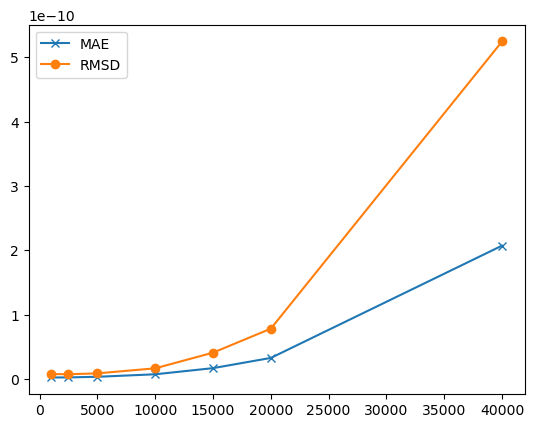

In [131]:
from math import sqrt
import matplotlib.pyplot as plt 

number_of_cells = []
maes = []
rmsds = []

for i in [10, 25, 50, 100, 150, 200, 400]:
    n = [100, i, 1]
    a1 = np.load(os.path.join("demag_calcs", f"demag_tensor_({n[0]},{n[1]},{n[2]}).npy"))
    b1 = np.load(os.path.join("demag_calcs", f"demag_tensor_({n[0]},{n[1]},{n[2]})_GPU.npy"))
    MAE = np.mean(np.abs(a1 - b1))
    RMSD = sqrt(np.mean((a1-b1)**2))
    print(f"[100, {i}, 1],  MAE : {MAE} and RMSD : {RMSD}")
    maes.append(MAE)
    rmsds.append(RMSD)
    number_of_cells.append(np.prod(n))

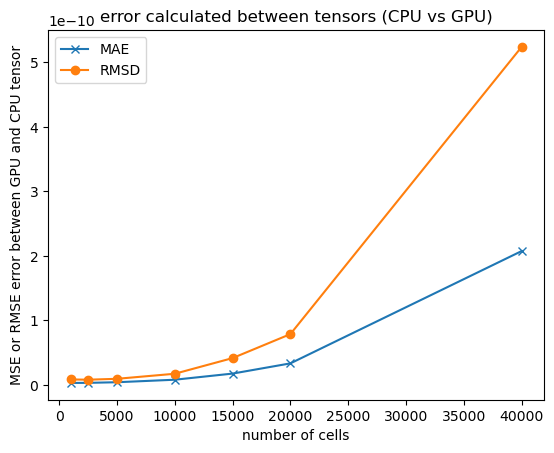

In [151]:
plt.title("error calculated between tensors (CPU vs GPU)")
plt.plot(number_of_cells, maes, "-x", label="MAE")
plt.plot(number_of_cells, rmsds,"-o" , label="RMSD")
plt.xlabel("number of cells")
plt.ylabel("MSE or RMSE error between GPU and CPU tensor")
plt.legend()
plt.show()

In [141]:
import matplotlib.pyplot as plt 

title_fs = 24
label_fs = 16

grid_size, times = [], []
for i in [5, 10, 25, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2622]:
    dx  = (1e-9, 1e-9, 1e-9)
    n   = (100, i, 1)
    t = time()
    cuda_calc = calculate_demag_tensor_cuda(n ,dx)
    grid_size.append(np.prod(n))
    times.append(time() - t)

a, b = 1.3752331398384698e-05, 0.07369147318715058

d:\Python\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (7) < 2 * SM count (28) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
d:\Python\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (14) < 2 * SM count (28) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


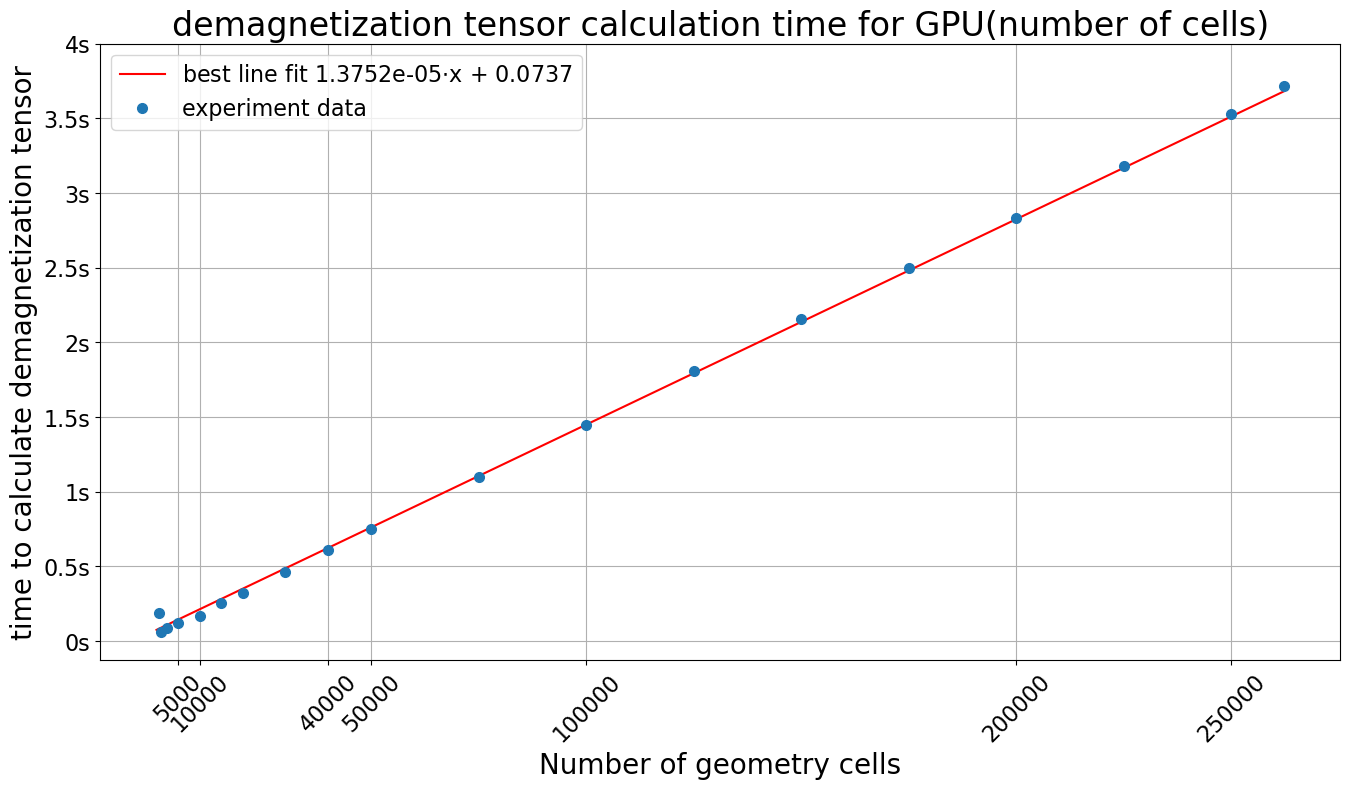

In [148]:
plt.figure(figsize=(16, 8))
plt.title("demagnetization tensor calculation time for GPU(number of cells)", fontsize=title_fs)
plt.plot([0, grid_size[-1]], [b, a * grid_size[-1] + b], label=f"best line fit {round(a, 9)}$\cdot$x + {round(b, 4)}", color="red")
plt.plot(grid_size, times, ".", markersize=14, label="experiment data")
plt.xlabel("Number of geometry cells", fontdict={"fontsize" : label_fs+4})
plt.ylabel("time to calculate demagnetization tensor", fontdict={"fontsize" : label_fs+4})
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], ["0s", "0.5s", "1s", "1.5s", "2s", "2.5s", "3s", "3.5s", "4s"], fontsize=label_fs)
plt.xticks([5000, 10000, 40000, 50000, 100000, 200000, 250000], [5000, 10000, 40000, 50000, 100000, 200000, 250000], 
            fontsize=label_fs, rotation=45)
plt.grid()
plt.legend(fontsize=label_fs)
plt.show()

In [121]:
grid_size, times

([500,
  1000,
  2500,
  5000,
  10000,
  15000,
  20000,
  30000,
  50000,
  75000,
  100000,
  125000,
  150000,
  175000,
  200000,
  225000,
  250000,
  262200],
 [0.21911025047302246,
  0.12871122360229492,
  0.08431386947631836,
  0.12770748138427734,
  0.16692233085632324,
  0.25211215019226074,
  0.31234288215637207,
  0.4629819393157959,
  0.7477583885192871,
  1.097886085510254,
  1.4447975158691406,
  1.7966728210449219,
  2.1420557498931885,
  2.4711341857910156,
  2.821908712387085,
  3.1625938415527344,
  3.51900315284729,
  3.695138454437256])

In [160]:
def MAE(a, b):
    return np.mean(np.abs(a-b))

def RMSD(a, b):
    return np.sqrt( np.mean( (a - b)**2 ))

def read_raw_data(filename):
    ts, mxs, mys, mzs = [], [], [], []
    with open(filename) as f:
        for line in f:
            t, mx, my, mz, _ = [float(v) for v in line.split()]
            ts.append(t)
            mxs.append(mx)
            mys.append(my)
            mzs.append(mz)
    return np.array(ts), np.array(mxs), np.array(mys), np.array(mzs)

cpu_t, cpu_mx, cpu_my, cpu_mz = read_raw_data(os.path.join("..", "data", "sp4_original.dat"))
gpu_t, gpu_mx, gpu_my, gpu_mz = read_raw_data(os.path.join("..", "data", "sp4_original_GPU.dat"))

MAE mx : 1.1000000000051767e-10


In [162]:
print(f"MAE mx : {MAE(cpu_mx, gpu_mx)}")
print(f"MAE my : {MAE(cpu_my, gpu_my)}")
print(f"MAE mz : {MAE(cpu_mz, gpu_mz)}")
print(f"RMSD mx : {RMSD(cpu_mx, gpu_mx)}")
print(f"RMSD my : {RMSD(cpu_my, gpu_my)}")
print(f"RMSD mz : {RMSD(cpu_mz, gpu_mz)}")


MAE mx : 1.1000000000051767e-10
MAE my : 1.0499999999939377e-10
MAE mz : 1.9999999999985307e-11
RMSD mx : 1.0488088481750873e-08
RMSD my : 1.0246950765900437e-08
RMSD mz : 4.472135954996294e-09


In [159]:
np(cpu_t - gpu_t)

array([0., 0., 0., ..., 0., 0., 0.])